# Maestría en Inteligencia Artificial Aplicada

# TC 4033: Visión computacional para imágenes y video

# Tecnológico de Monterrey

## Dr. Gilberto Ochoa Ruiz

# **6.4 Google Colab - Extracción de líneas con algoritmo de Canny**

## **Equipo # 16**
### Edwin David Hernández Alejandre A01794692
### Miguel Guillermo Galindo Orozco A01793695
### Jorge Pedroza Rivera A01319553
### Juan Carlos Alvarado Carricarte A01793486
### Gerardo Aaron Castañeda Jaramillo A01137646


## Table of Contents
1. [Libraries](#libraries)
2. [Canny Edge Detection](#canny)
3. [Conclusiones](#conclusiones)
4. [Referencias](#referencias)

## Importing Libraries <a class="anchor" id="libraries" ></a>

In [1]:
import cv2
import skimage
import numpy as np
from scipy import ndimage
from skimage import exposure
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.ndimage.filters import convolve
from scipy.ndimage.filters import gaussian_filter as gauss
from scipy.ndimage.filters import median_filter as med

C:\Users\G\AppData\Local\Temp\ipykernel_23868\29601034.py:9: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import convolve
C:\Users\G\AppData\Local\Temp\ipykernel_23868\29601034.py:10: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter as gauss
C:\Users\G\AppData\Local\Temp\ipykernel_23868\29601034.py:11: DeprecationWarning: Please use `median_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import median_filter as med


## Canny Edge Detection <a class="anchor" id="canny" ></a>

El algoritmo de detección de bordes Canny es altamente efectivo para detectar bordes en imágenes con un bajo nivel de ruido. Consiste de los siguientes pasos:

1. Noise Reduction
2. Gradient Calculation
3. Non-maximum Supression
4. Double Threshold
5. Edge Tracking by Hysteresis

**Pre-requisite:** Convert the image to grayscale before algorithm.

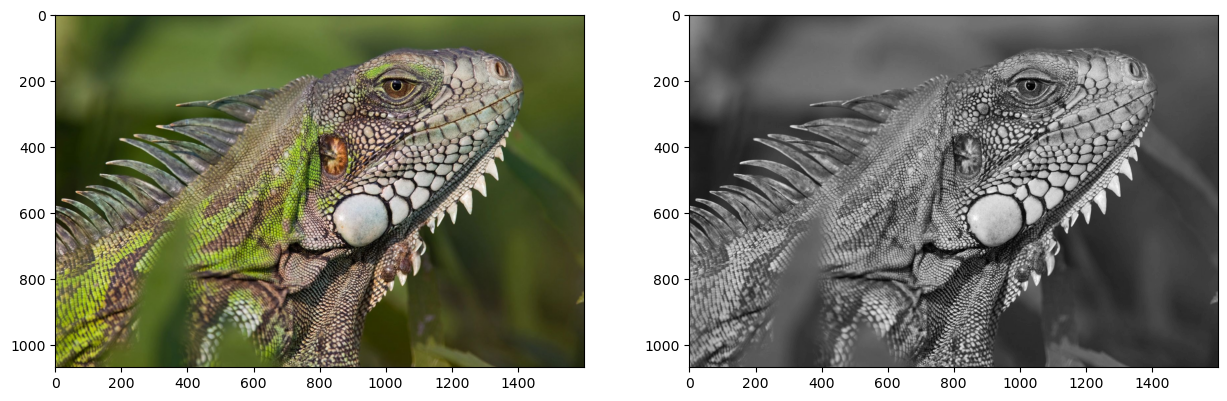

In [2]:
img = cv2.imread('data/green-iguana.jpg')

img_color = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.imshow(img_color)
plt.subplot(1, 2, 2)
plt.imshow(img_gray, cmap="gray")

### 1. Noise Reduction
Edge detection are highly sensitive to image noise due to the derivatives behind the algorithm.

We can apply a Gaussian Kernel, the size of the kernel depends on the expected blurring effect. The smaller the less blurring effect.

Equation for Gaussian Kernel of size $(2k+1) \times (2k+1)$

$$
H_{i, j} = \frac{1}{2\pi\sigma^2}exp(-\frac{(i-(k+1))^2 + (j-(k+1))^2}{2\sigma^2}); 1\leq i, j \leq (2k+1)
$$

In [3]:
def gaussian_kernel(size, sigma=1):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return g

### 1.1 Sigma Parameter $\sigma$

In [25]:
# Change this parameter
sigma = 10 # 1, 3, 5, 10, 20, ...
sigma_list = [1, 5, 10, 20, 50, 100]

### 1.2 Kernel Size Parameter

In [26]:
kernel_size = 3
kernel_size_list = [3, 5, 10, 20, 100]

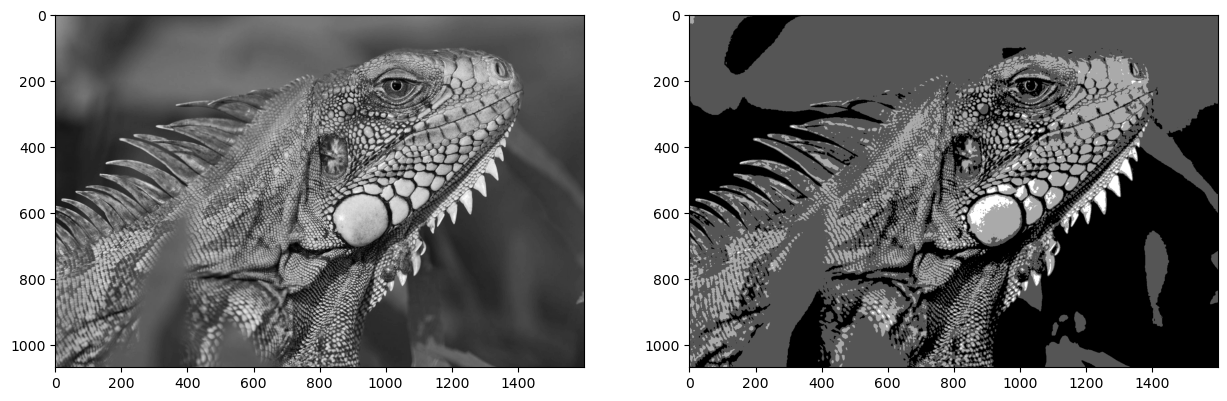

In [27]:
img_gaussian = convolve(img_gray, gaussian_kernel(kernel_size, sigma))

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.imshow(img_gray, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(img_gaussian, cmap="gray")

Ahora probamos generar un grid donde podamos observar los resultados del filtro gaussiano, variando sigma y el tamaño del kernel. El filtro ayuda a reducir la detección de bordes falsos eliminado el ruido. 
Iteramos a través de sigma [1, 5, 10, 20, 50, 100] y kernel_size [3, 5, 10, 20, 100]

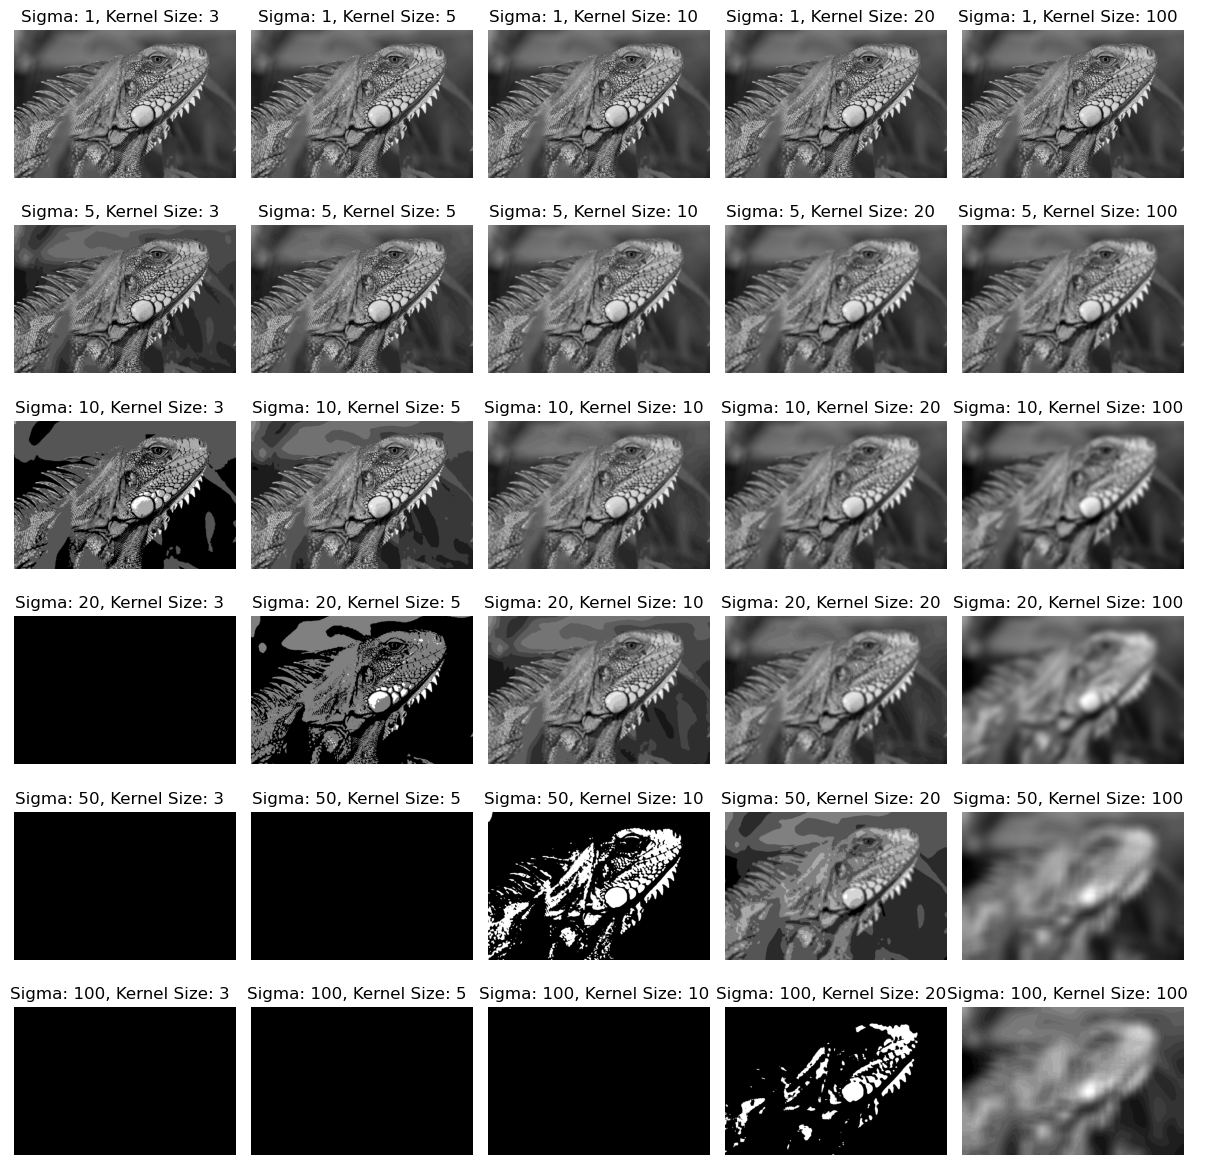

In [7]:
fig, axs = plt.subplots(6, 5, figsize=(12, 12))

# Loop through each combination of options
for i in range(len(sigma_list)):
    for j in range(len(kernel_size_list)):
                   
        img_gaussian_temp = convolve(img_gray, gaussian_kernel(kernel_size_list[j], sigma_list[i]))
        axs[i, j].imshow(img_gaussian_temp, cmap='gray')  # Change cmap and other parameters as needed
        
        axs[i, j].axis('off')
        
        # Add titles or labels if needed
        axs[i, j].set_title(f"Sigma: {sigma_list[i]}, Kernel Size: {kernel_size_list[j]}  ")

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the figure
plt.show()

Decidimos quedarnos con kernel_size = 3 y sigma = 10. 

### 2. Gradient Calculation

Edges correspond to a change of pixels intensity. 

To detect it, the easiest way is to apply filters that highlight this intensity change in both directions: 
- horizontal $(x)$ 
- and vertical $(y)$

It can be implemented by convoling $I$ with *Sobel kernels* $Kx$ and $Ky$

$$
K_x = \begin{bmatrix}
-1 & 0 & 1\\
-2 & 0 & 2\\
-1 & 0 & 1
\end{bmatrix}, K_y = \begin{bmatrix}
1 & 2& 1\\
0 & 0 & 0\\
-1 & -2 & -1
\end{bmatrix}
$$

Then, the magnitude $G$ and the slope $\theta$ of the gradient are calculated as follow:

$$
|G| = \sqrt{I_x^2 + I_y^2},
\theta(x, y) = arctan(\frac{I_y}{I_x})
$$

In [22]:
def sobel_filters(img):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
    
    Ix = ndimage.filters.convolve(img, Kx)
    Iy = ndimage.filters.convolve(img, Ky)
    
    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)
    
    return (G, theta)

Observamos el efecto de filtro de sobel sin haber aplicado la reducción de ruido:

C:\Users\G\AppData\Local\Temp\ipykernel_23868\65442114.py:5: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  Ix = ndimage.filters.convolve(img, Kx)
C:\Users\G\AppData\Local\Temp\ipykernel_23868\65442114.py:6: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  Iy = ndimage.filters.convolve(img, Ky)


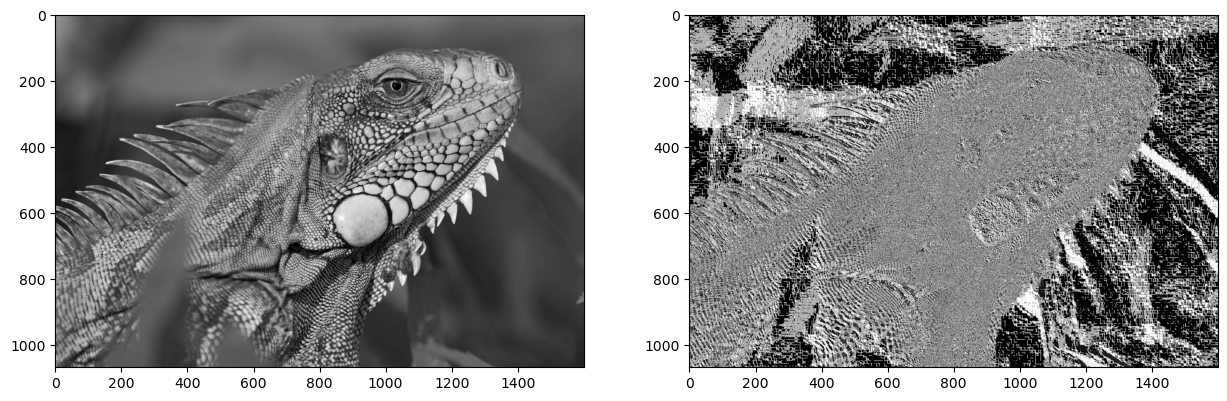

In [28]:
G, theta = sobel_filters(img_gray)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.imshow(img_gray, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(G, cmap="gray")

Ahora observamos el filtro de sobel donde si se aplico el filtro gaussiano:

C:\Users\G\AppData\Local\Temp\ipykernel_23868\65442114.py:5: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  Ix = ndimage.filters.convolve(img, Kx)
C:\Users\G\AppData\Local\Temp\ipykernel_23868\65442114.py:6: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  Iy = ndimage.filters.convolve(img, Ky)


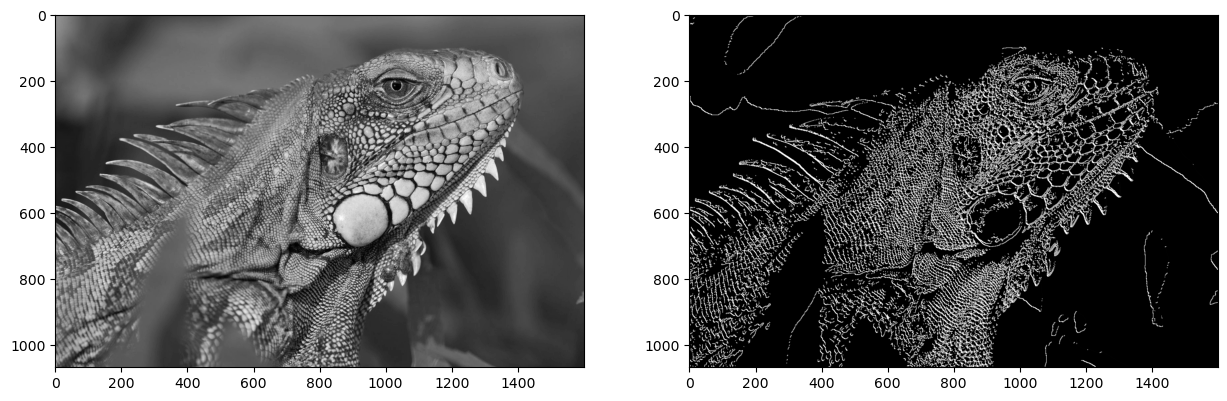

In [29]:
G_nr, theta_nr = sobel_filters(img_gaussian)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.imshow(img_gray, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(G_nr, cmap="gray")

Efectivamente, es claro desde este paso que reducir el ruido ayuda a la detección de bordes en el método de canny.

### 3. Non-Maximum supression

1. Create a matrix initialized to 0 of the same size of the original gradient intensity matrix
2. Identify the edge direction based on the angle value from the angle matrix
3. Check if the pixel in the same direction has a higher intensity than the pixel that is currently processed
4. Return the image processed with the non-max suppression algorithm.

In [32]:
def non_max_suppression(img, D):
    M, N = img.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180

    
    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                q = 255
                r = 255
                
               #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]

                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0

            except IndexError as e:
                pass
    
    return Z

Observamos de referencia el resultado de no haber aplicado reducción de ruido:

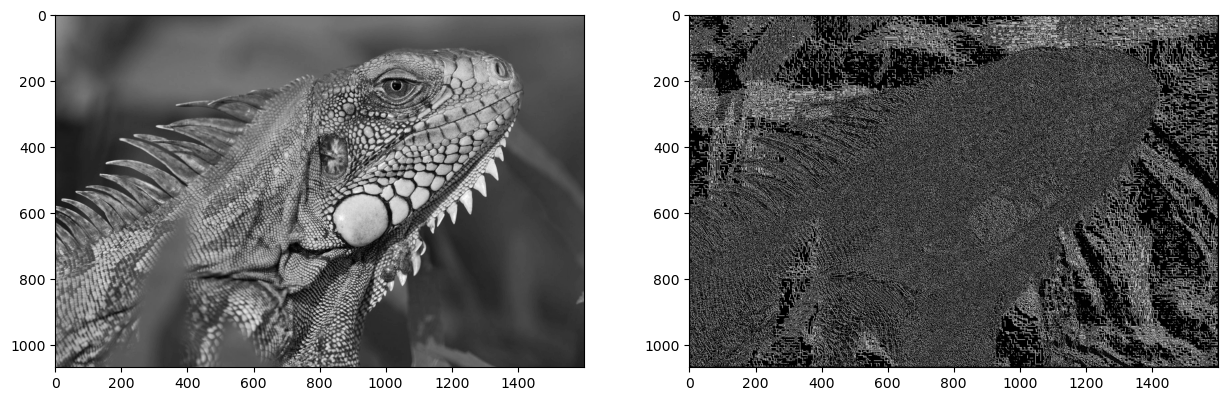

In [33]:
img_nonmax = non_max_suppression(G, theta)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.imshow(img_gray, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(img_nonmax, cmap="gray")

Seguimos con el método aplicado correctamente:

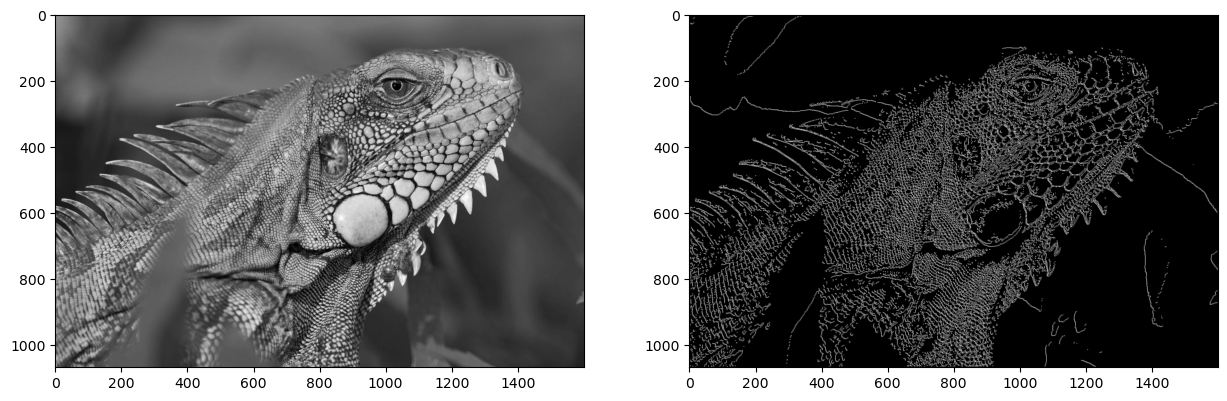

In [35]:
img_nonmax_nr = non_max_suppression(G_nr, theta_nr)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.imshow(img_gray, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(img_nonmax_nr, cmap="gray")

### 4. Double threshold

- Strong pixels are pixels that have an intensity so high that we are sure they contribute to the final edge.
- Weak pixels are pixels that have an intensity value that is not enough to be considered as strong ones, but yet not small enough to be considered as non-relevant for the edge detection.
- Other pixels are considered as non-relevant for the edge.

In [36]:
def threshold(img, lowThresholdRatio=0.05, highThresholdRatio=0.09):
    
    highThreshold = img.max() * highThresholdRatio;
    lowThreshold = highThreshold * lowThresholdRatio;
    
    M, N = img.shape
    res = np.zeros((M,N), dtype=np.int32)
    
    weak = np.int32(25)
    strong = np.int32(255)
    
    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)
    
    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))
    
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak
    
    return (res)

De nuevo, observamos el resultado final de no haber aplicado reducción de ruido. 

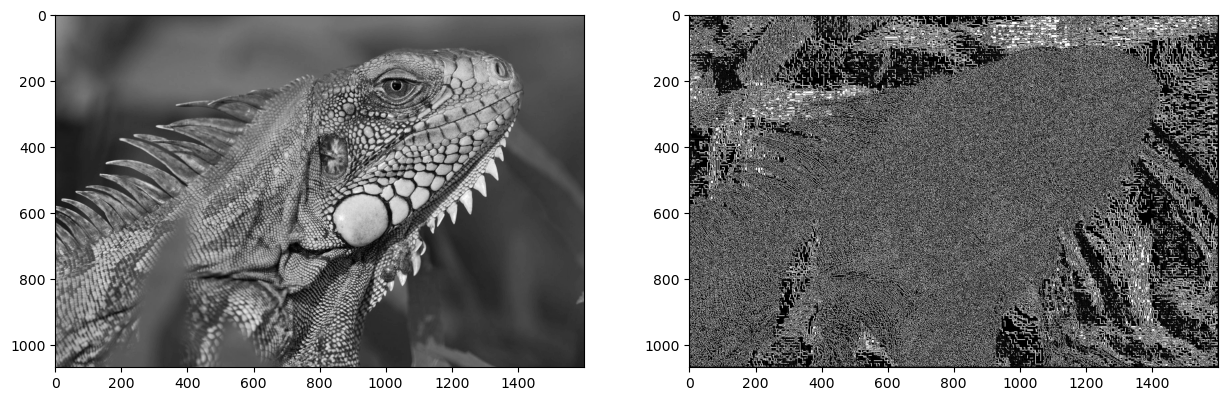

In [48]:
img_threshold = threshold(img_nonmax, 0.01, 0.09)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.imshow(img_gray, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(img_threshold, cmap="gray")

Observamos el resultado final del método de canny:

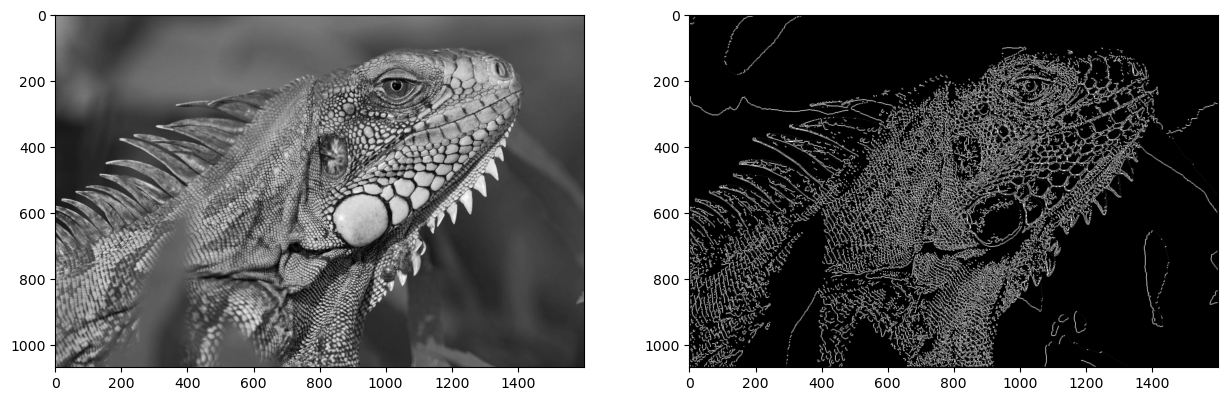

In [52]:
img_threshold_nr = threshold(img_nonmax_nr, 0.01, 0.5)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.imshow(img_gray, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(img_threshold_nr, cmap="gray")

### 5. Edge Tracking by Hysteresis

The hysteresis consists of transforming weak pixels into strong ones, if and only if at least one of the pixels around the one being processed is a strong one

In [39]:
def hysteresis(img, weak = 75, strong=255):
    M, N = img.shape  
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i,j] == weak):
                try:
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                        or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                        or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        img[i, j] = strong
                    else:
                        img[i, j] = 0
                except IndexError as e:
                    pass
    return img

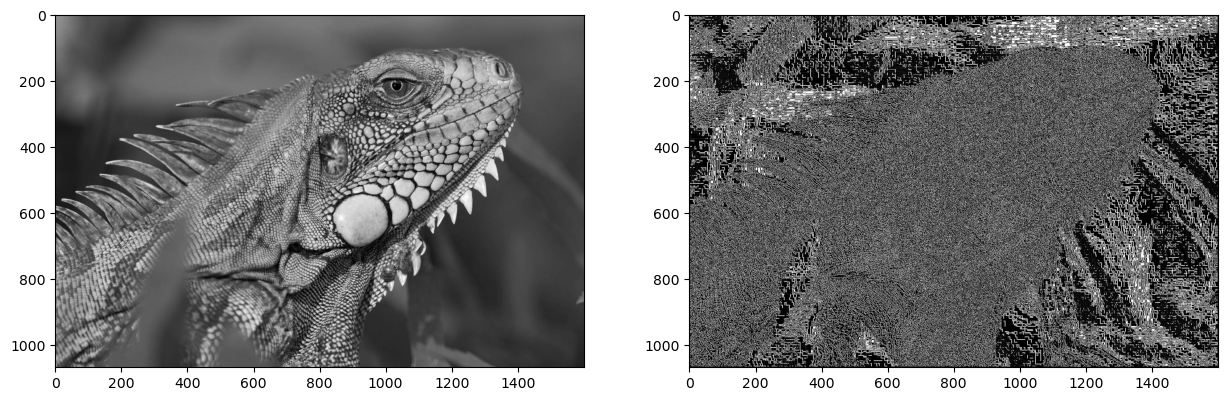

In [43]:
img_final = hysteresis(img_threshold, 75, 255)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.imshow(img_gray, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(img_final, cmap="gray")

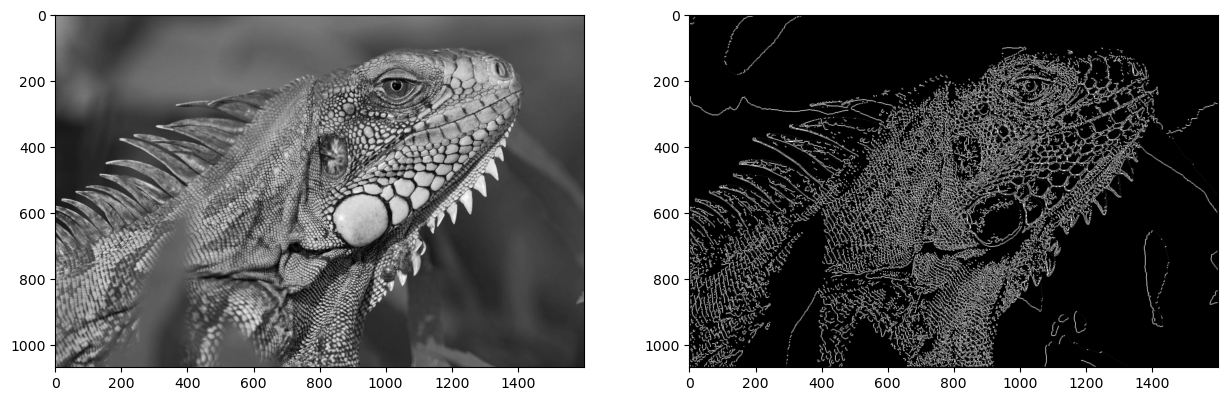

In [44]:
img_final = hysteresis(img_threshold_nr, 75, 255)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.imshow(img_gray, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(img_final, cmap="gray")

## Conclusiones <a class="anchor" id="conclusiones" ></a>

El método de detección de bordes de Canny es bastante efectivo y robusto en su aplicación. Un paso importantísimo es la reducción de ruido al inicio. Como fue posible observar durante todo el ejercicio, aplicar el filtro gaussiano hizo una gran diferencia en el resultado final del método. El calculo del gradiente permite identificar los cambios bruscos en la intensidad de la imagen. Esto ayuda a la detección de los bordes. El variar el operador de la derivada, así como el operador de sobel, y la orientación del gradiente, influyen en la detección de bordes en diferentes direcciones. 

La supresión de no máximos ayuda a refinar la detección de bordes. En este paso se eliminan los pixeles que no son máximos locales en la dirección del gradiente. Aplicado adecuadamente, garantiza que los bordes detectados sean delgados y bien definidos. El doble threshold, determina cuales pixeles se clasificarán como bordes fuertes, bordes débiles, o pixeles no relevantes. Aquí se define la sensibilidad y selectividad del algoritmo en la detección de bordes. 
Mientras el seguimiento de bordes por histéresis, ayuda a conectar los bordes débiles y eliminar los pixeles de ruido. Garantizando la continuidad de los bordes detectados. El seleccionar un umbral adecuado es importantísimo para evitar la discontinuidad de los bordes. 

Nosotros al aplicar el filtro gaussiano, decidimos quedarnos una sigma de 10 y un kernel de 3. Esto porque observamos que era la combinación que nos permitía conservar los bordes de la iguana, y ayudaba a eliminar el ruido del fondo. Al mover valores en el calculo del gradiente, y en la supresión de no máximos, decidimos dejarlos como en el ejemplo. Es notorio el efecto que tiene, pero se decidió quedarse con los mismos ya que fue lo que nos dio mejores resultados. De manera similar, nos sucedió para el doble umbral. Aunque se jugo con los valores de los thresholds, no se logro observar cambio significativo en nuestra imagen resultante. No se logro mejorar el resultado de los valores del ejemplo. Se concluye que es debido a los pasos anteriores donde ya se dejaban bien definidos los bordes. 

## Referencias <a class="anchor" id="referencias" ></a>

* Gonzalez, R., & Woods, R. (2018). Digital Image Processing. Pearson.
* OpenCV. (n.d.). Canny Edge Detection. Retrieved from OpenCV: https://docs.opencv.org/4.x/da/d22/tutorial_py_canny.html
* OpenCV. (n.d.). Canny Edge Detector. Retrieved from OpenCV: https://docs.opencv.org/3.4/da/d5c/tutorial_canny_detector.html
* Reyes, I. (2023). 3. Sobel and Canny Edge Detection. Retrieved from Github: https://github.com/CV-INSIDE/computer-vision-course/blob/main/3_sobel_canny_edge_detection.ipynb
* Rosebrock, A. (2021). OpenCV Edge Detection (cv2.Canny). Retrieved from pyimagesearch: https://pyimagesearch.com/2021/05/12/opencv-edge-detection-cv2-canny/
* Sahir, S. (2019). Canny Edge Detection Step by Step in Python — Computer Vision. Retrieved from Medium: https://towardsdatascience.com/canny-edge-detection-step-by-step-in-python-computer-vision-b49c3a2d8123


